In [33]:
#2DPotential: use x-y coords of wire path to map out potential energy for a magnet on the surface
#CKH 6-24-18
#Goal is to estimate forces on real magnets from embroidered 2D magnet wire patterns carrying a constant current.
import numpy as np

Br = 1.3200 #residual magnetic flux density for N42 grade NdFeB in tesla (1T = 10000 Gausss, usually Br is given as 13200 Gauss) 
#https://www.kjmagnetics.com/blog.asp?p=magnet-grade
m0=4.0*np.pi*10e-7 #permeability of free space in H/m
dV=1.0 #magnet volume, I'm sticking with 1 cubic meter to start out
m=Br*dV/m0 #Magnetic moment of magnetic voxel (z-direction) in A/m^2 
#Later will scale it down for a smaller voxel size, where voxel dimensions are set by meshgrid step size
I=0.4 #Wire current in Amps
MultiplierThing=m*m0*I/(4.0*np.pi) #constant that frequenty appears in front of integrals

#MagnetThickness=0.001#magnet thickness in meters, for simulating a 3 mm thick magnet in 3 1-mm slices
MagnetThickness=0.003
MagnetWidth=0.0127 #Magnet width in meters (it's a circle) - more later -D82 magnet from kjmagnetics

#ZShift=0.0005 #ZShift in meters - How far from the surface is the magnet. 
#ZShift=0.0015 #middle slice
#ZShift=0.0025 #top slice  - I'm running it at 3 different z-shifts, getting the force for each slice and summing them
ZShift=0.0013  #this single slice height gives very close to same values for the whole magnet as the 3 slice approach

In [34]:
#Read in the embroidery stitch locations in comma-separated variable format x (mm), y(mm)


#inputfile='FlatSpiral.csv' #This is the Flat Spiral pattern illustrated in figure 2a. 
#inputfile='FlatHelix.csv'#This is the Flat Helix pattern in figures 1(photo) and 2b (illustration). When
inputfile='SquareCoil.csv' #This is the Square Coil pattern illustrated in Figure 2c. 
#The patterns have a pitch of 13 mm.


#Scale the data to meters.
stitchdata= np.loadtxt(inputfile, delimiter=',')
xseries=np.array(stitchdata[:,0])/1000.0 
yseries=np.array(stitchdata[:,1])/1000.0 

In [35]:
def wirelength(xseries,yseries):  #Get wire length to compare different designs
    wlen=0
    for i in range(len(xseries)-1):
        wlen += np.sqrt((xseries[i+1]-xseries[i])**2+(yseries[i+1]-yseries[i])**2)
    return wlen

wirelength(xseries,yseries) #wire length of entire pattern in meters. 
#Divide by 8 to get wire length per coil for these 8-coil patterns.

3.0222364044053309

In [36]:
#Define functions to compute potential energy U from individual segments, 
#these expressions come from U=-m dot B, and B= curl of the magnetic vector potential
#Because m is in the z direction we need only evaluate z component of the curl.
#The magnetic vector potential is integral of dI/r where r is the distance between an observer at (x,y,zshift) and the current segment at (x', y', 0)
#(multiplied by some constants called MultiplierThing)
def uVert(x,y,x0,y0,y1):  #special case for a vertical segment along y, avoids dividing by 0
    Part1=(y1-y)*(x0-x)/np.sqrt((x0-x)**2+ZShift**2+(y1-y)**2)   #this function also handles a duplicate stitch (0-length segment)
    Part2=(y0-y)*(x0-x)/np.sqrt((x0-x)**2+ZShift**2+(y0-y)**2)
    result = -MultiplierThing*(Part1-Part2)/((x0-x)**2+ZShift**2)
    return result

def uGen (x,y,x0,y0,x1,y1): #General case works for sloped or horizontal segments
    M=(y1-y0)/(x1-x0) #Slope of this segment
    B=y0-M*x0  #y-intercept of this segment
    A=1.0+M**2  #These constants A, C, D appear in the closed-form integral solution
    C=2.0*(M*B-M*y-x)
    D=x**2+(B-y)**2+ZShift**2 
    Zerotest1=C**2-4*A*D  #expressions used in denominators below. If they are 0, will cause error
    Zerotest2=x1*(A*x1+C)+D
    Zerotest3=x0*(A*x0+C)+D
    
    PileOfThings=(y-M*x-B)*2.0/Zerotest1
    Part1=(2.0*A*x1+C)/np.sqrt(Zerotest2)  
    Part2=(2.0*A*x0+C)/np.sqrt(Zerotest3)
    result=MultiplierThing*PileOfThings*(Part1-Part2)
    return result
    


    

In [37]:
#Map out potential energy of a single voxel magnet over the whole design
dx=0.25/1000 #x delta in meters for plotting
dy=dx #y delta in meters for plotting -- I made it to be same as dx

border =0.005 #border width in meters to draw around edges of imported pattern

xs=np.arange(np.min(xseries)-border,np.max(xseries)+border,dx) 
ys=np.arange(np.min(yseries)-border,np.max(yseries)+border,dy) 
X,Y=np.meshgrid(xs,ys)      


VolumeScaler = dx*dx*MagnetThickness #magnet voxel volume multiplier

U=0.0 
for i in range(1,len(xseries)):
    if np.abs(xseries[i]-xseries[i-1])< 0.0002: #this segment is essentially vertical-- machine can only distinguish 0.1 mm differences
        U=U+uVert(X,Y,xseries[i-1],yseries[i-1],yseries[i])
    else:
        U=U+uGen(X,Y,xseries[i-1],yseries[i-1],xseries[i],yseries[i])
U=U*VolumeScaler  #account for the size of a magnetic "voxel"

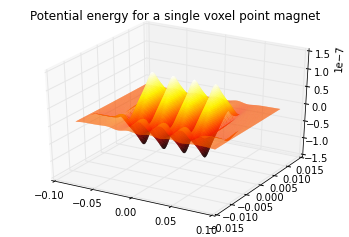

In [38]:
#Plot the single voxel magnet's potential energy landscape
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X,Y,U, rstride=1, cstride=1, cmap='hot', linewidth=0, antialiased=True)
plt.hold('true')
plt.title('Potential energy for a single voxel point magnet')

plt.show()
#plot may be spiky if zshift is small, because you start seeing the extremely high field at the wire surface. the spikes will
#smooth out when we average the potential energy over the entire magnet

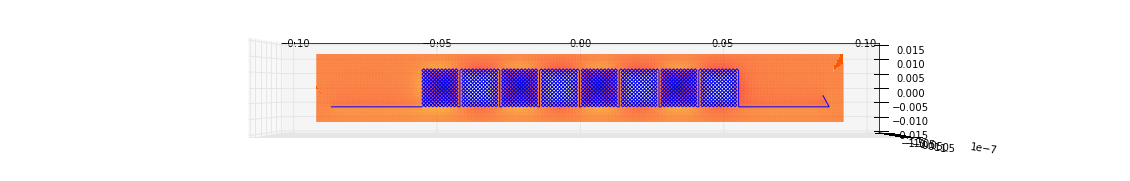

In [39]:
#Show the single-voxel potential energy landscape as a colormap aligned with the coil pattern

fig = plt.figure(figsize=[20,3])
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X,Y,U, rstride=1, cstride=1, cmap='hot', linewidth=0, antialiased=True)
plt.axis('equal')
plt.hold('true')
plt.plot(xseries,yseries)

ax.view_init(elev=90., azim=-90.)
#plt.savefig('PotentialMapWithCoilOnIt.eps')
plt.show()

In [40]:

#Now need to sum the potential energy over a magnet that has a similar size to an individual coil.
N=int(np.round(MagnetWidth/dx)) #number of chunks to divide magnet into (NxN)-- I made dx and dy have to be the same
#Magnet width is set in the top cell of this notebook

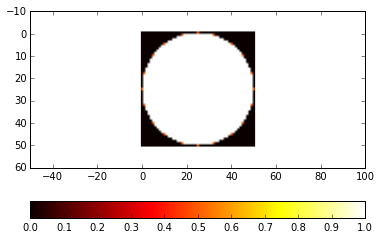

In [41]:
#Magnet grid has to match the U grid
#So if you want a finer magnet grid, decrease dx and dy above

k = np.ones((N,N)) #A square magnet, N meshgrid increments x N meshgrid increments

def roundfilt(N):  #Creates a rounded filter kernel that resembles a round 2D magnet
    filtrad=np.floor(N/2)
    filt=np.ones((N,N))
    for i in range(N):
        for j in range(N):
            if ((i-filtrad)**2+(j-filtrad)**2)>filtrad**2:
                filt[i,j]=0.0
            else:
                if((i-filtrad)**2+(j-filtrad)**2)>(filtrad**2-float(N)/10):  #blur the edge a litle
                    filt[i,j]=0.5
          
    return filt
 
#Uncomment the line below if you want a circular instead of square magnet
k=roundfilt(N)

 
#Show the magnet shape. x-y coords are in units of dx. 
im=plt.imshow(k,cmap='hot')
plt.colorbar(im,orientation='horizontal')
plt.axis('equal')
plt.show()

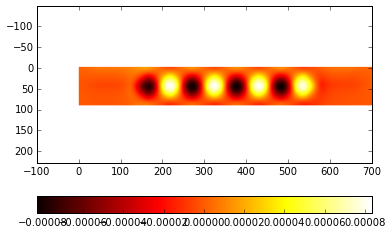

In [42]:
#Do the summing of U over the magnet, and plot its value at the magnet's center location

from scipy import signal
Uavg=signal.convolve2d(U,k,boundary='symm',mode='same') #Equivalent of matlab filter2 with zero padding to stay same size
#energy will be joules 
im = plt.imshow(Uavg, cmap='hot')
plt.colorbar(im, orientation='horizontal')
plt.axis('equal')
#plt.savefig('PotentialMapForCoil.png')
plt.show()



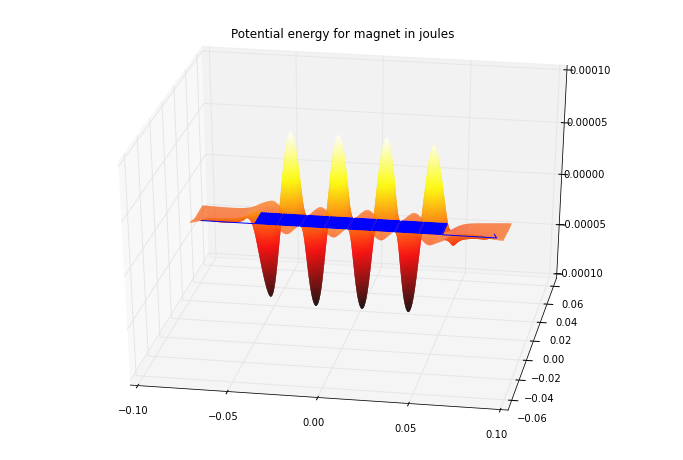

In [43]:
#3D energy landscape for the whole magnet at the magnet's center location, aligned with coil pattern plot
fig = plt.figure(figsize=[12,8])
ax = fig.gca(projection='3d')

ax.plot_surface(X,Y,Uavg, rstride=1, cstride=1, cmap='hot', linewidth=0, antialiased=True)
plt.title('Potential energy for magnet in joules')
ax.view_init(elev=30., azim=-80.)
plt.hold('true')
plt.plot(xseries,yseries)
plt.axis('equal')
#plt.savefig('3DPotentialWithCoil.eps')
plt.show()
#z axis joules, x-y meters


0.021566940427568931

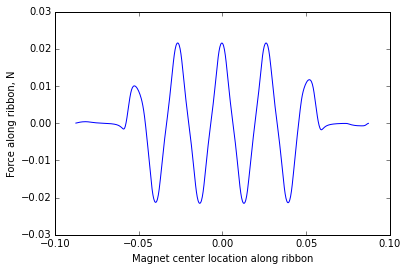

In [44]:

#Take the gradient of this field to get the force 
#This force is the max load the magnet can hold off, but f=ma can not be used to get the average speed
#because the magnet stops moving once it falls to the bottom of the potential well.
#The average speed is set by the rate we switch the current through the coil pair.
#(as long as it isn't too fast for the magnet to keep up by f=ma).
#X component of the gradient is the force we care about for along-ribbon motion.

force=np.gradient(Uavg,dx,dy) #
fy=-force[0]  #force across ribbon width
fx=-force[1] #force along ribbon length

#Use this to plot out force along some parallel paths down the center of the ribbon
#xstripe=np.swapaxes(fx[(len(ys)/2-5):(len(ys)/2+5),:],0,1)
#plt.plot(xstripe) 

#plt.hold('true')
fxmiddle=fx[len(ys)/2,:]#This should be the path down the center
plt.plot(xs,fxmiddle)
plt.xlabel('Magnet center location along ribbon')
plt.ylabel('Force along ribbon, N')
np.max(abs(fxmiddle)) #get maximum value of x-force, for comparing designs. This result is for a single set of coils.


In [45]:
#The actuators have 2 sets of coils shifted half a coil width. 
#We can manually superpose force from 2 sets of coils, below


[0, 0.18124999999999999, -0.031940651693651768, 0.032009424083938538]

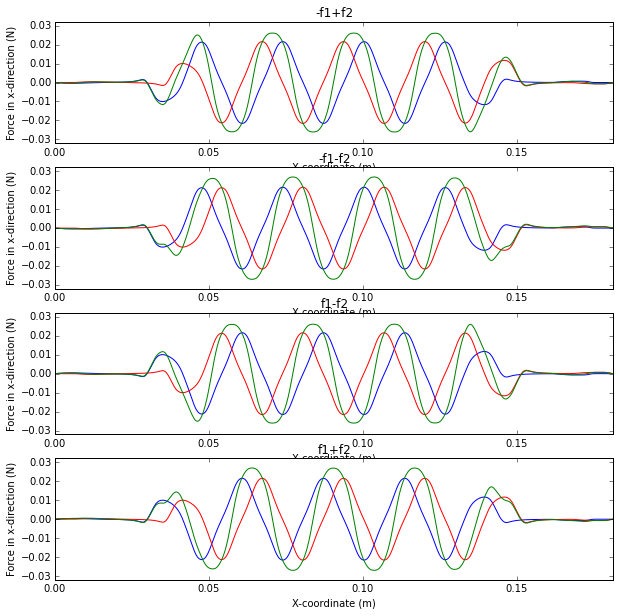

In [46]:
#Combined coil x-force: For all 3 example designs the pitch is 13 mm
#Shift the force vector over by half a pitch and add/subtract it from the original vector
#There are 4 possible combination of add/subtract corresponding to the 4 parts of the motion cycle.

#Create shifted force vector
halfpitch=0.013/2
nshift=int(np.round(halfpitch/dx))#how many increments to shift over?
f1=np.zeros(len(fxmiddle)+nshift)
f2=np.zeros(len(f1))
f1[0:len(fxmiddle)]=fxmiddle
f2[-len(fxmiddle):]=fxmiddle
xpandedx=np.arange(len(f1))*dx

#Plot the 4 cycles
myaxes=[0,xpandedx[-1],np.min(f1+f2)-0.005,np.max(f1+f2)+0.005]
plt.figure(figsize=[10,10])
plt.subplot(4,1,1)
plt.plot(xpandedx,-f1)
plt.plot(xpandedx,f2,'r')
plt.plot(xpandedx,-f1+f2,'g') #net force is plotted in green
plt.xlabel('X-coordinate (m)')
plt.ylabel('Force in x-direction (N)')
plt.title('-f1+f2')

plt.axis(myaxes)
plt.subplot(4,1,2)
plt.plot(xpandedx,-f1)
plt.plot(xpandedx,-f2,'r')
plt.plot(xpandedx,-f1-f2,'g') #net force is plotted in green
plt.xlabel('X-coordinate (m)')
plt.ylabel('Force in x-direction (N)')
plt.title('-f1-f2')

plt.axis(myaxes)
plt.subplot(4,1,3)
plt.plot(xpandedx,f1)
plt.plot(xpandedx,-f2,'r')
plt.plot(xpandedx,f1-f2,'g') #net force is plotted in green
plt.xlabel('X-coordinate (m)')
plt.ylabel('Force in x-direction (N)')
plt.title('f1-f2')

plt.axis(myaxes)
plt.subplot(4,1,4)
plt.plot(xpandedx,f1)
plt.plot(xpandedx,f2,'r')
plt.plot(xpandedx,f1+f2,'g') #net force is plotted in green
plt.xlabel('X-coordinate (m)')
plt.ylabel('Force in x-direction (N)')
plt.title('f1+f2')

plt.axis(myaxes)
#plt.savefig('forceplot.eps')
#Show the four parts of the cycle here. -f1+f2,-f1-f2,f1-f2,f1+f2

In [47]:
#See how the green wave moves as the blue and red are cycled by sending either "forward" or "backward" currents through
#those coils. 
#Wave surfing would be a more accurate analogy to a plot of U though.
#Get the maximum force, whether it's for f1+f2 or f1-f2, they are close -- I will average
peakforce=(np.max(f1+f2) + np.max(f1-f2))/2.0
np.max(f1+f2), np.max(f1-f2) #Peak force for the non-interleaved flat helix and flat spiral designs



(0.027009424083938537, 0.026074187677360951)

In [48]:
peakforce #newtons

0.026541805880649742